# Collecting Typical Blobs based on pre-detected cells

To do list - For pair-wise matching perceptron, on single section first, then extent to multiple nearby sections
1. Get the contour for each structure
2. Get the marginal area for each strucutre 
3. Get the blobs in each structure 
4. Get the blobs in the marginal area of a structure
5. Compute pair-wise similarity vector, construct training set
6. Feed training set into the perceptron. Train with positive and negative examples
7. Get the weight for collecting blob
8. repeat the above process for multiple structures and see if the weight vaires a lot for different structure
9. Extend the algorithms to multiple sections
10. ....

### Conclusions:
1. Suppose that all the blobs detected within the annotation structures are typical and those blobs in the margin of the structure are not typical(negative training set). In N7, inituitively I thing the large cells are typical while the small cells are not typical(since they are quite similar with the surrounding cells. As a result, the positive training set is too noisy. 
2. The perceptron gives unnormalized weight. Moreover, some of the weights are negative. How to get a normalized, positve-definite weight? Modify the stochastic gradient descent, use Langraian operator and normalized the weight in every single iteration? Not sure if it works. 
3. The result of perceptron is highly unstable. The training accuracy varies a lot between trainings with the same data set. I gauss it depends on the order of the input data. Maybe using some ohter method with global optimization will be better?


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys, os, time

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'annotation'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'learning'))
import matplotlib.pyplot as plt
import numpy as np
import scipy
import skimage
from skimage.measure import regionprops
from skimage.filters import threshold_otsu
from scipy.ndimage.morphology import distance_transform_edt
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.transform import resize
from skimage.color import rgb2hsv
from scipy import ndimage as ndi
import pandas
from scipy.signal import argrelmax
from scipy.stats import linregress

from annotation_utilities import *
from registration_utilities import *
from learning_utilities import *
from data_manager import *
from utilities2015 import *
from cell_utilities import *
from metadata import *
from distributed_utilities import download_from_s3

Setting environment for AWS compute node


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


In [2]:
save_folder_path = '/shared/MouseBrainAtlasXiang/XJ/Output/Bolb_detection_with_predetected_cells/'
from xj_utilities import *
fun_create_folder(save_folder_path=save_folder_path)

Folder already exists: /shared/MouseBrainAtlasXiang/XJ/Output/Bolb_detection_with_predetected_cells/

In [3]:
def fun_radius_bbox(min_0, min_1, max_0, max_1):
    """
    radisu_bbox(min_0, min_1, max_0, max_1), correspond to the order of regionprops.bbox tuple
    """
    radius = 0.5 * ((max_1 - min_1)**2 + (max_0 - min_0)**2) ** 0.5
    return radius

def fun_crop_images(image, min_0, min_1, max_0, max_1, margin=0,im0max=10000,im1max=10000):
    min_0 = max(min_0-margin,0)
    max_0 = min(max_0+margin,im0max)
    min_1 = max(min_1-margin,0)
    max_1 = min(max_1+margin,im1max)
    crop_image = image[min_0:max_0, min_1:max_1].copy()
#     print((min_0, min_1, max_0, max_1))
    return crop_image

def fun_scan_range(cloc,radius,im1max=10000,im0max=10000,o_form='1D'):
    cloc = np.array(cloc);
    min_0 = int(max(np.round(cloc - radius)[0],0))
    min_1 = int(max(np.round(cloc - radius)[1],0))
    max_0 = int(min(np.round(cloc + radius)[0],im0max))
    max_1 = int(min(np.round(cloc + radius)[1],im1max))
    local_cloc = (int(cloc[0] - min_0), int(cloc[1] - min_1))
    if o_form == '1D':
        return (min_0, min_1, max_0, max_1), local_cloc
    elif o_form == '2D':
        return np.array([[min_0,min_1],[min_0,max_1],[max_0,max_1],[max_0,min_1]]), local_cloc

def fun_local_distance(blob_loc_tuple, local_cloc_tuple):
    r = ((blob_loc_tuple[0] - local_cloc_tuple[0]) ** 2 + ((blob_loc_tuple[1] - local_cloc_tuple[1]) ** 2) ) ** 0.5
    return r

def fun_similarity(oriIprops,nextIprops,distance_type='euclid'):
    similarity = [];
    num_blob = len(nextIprops);
    pi = 3.1415926
    for i in range(num_blob):
        if distance_type == 'euclid':
            difference = abs(oriIprops - nextIprops[i])/abs(float(max(oriIprops, nextIprops[i])) + 0.000000000001)
        elif distance_type == 'area':
            difference = abs(oriIprops - nextIprops[i])/(float(max(oriIprops, nextIprops[i])) + 0.000000000001)
        elif distance_type == 'eccentricity':
            difference = abs(oriIprops - nextIprops[i])/(float(max(oriIprops, nextIprops[i])) + 0.000000000001)
        elif distance_type == 'moments_hu':
            difference = np.abs(np.abs(oriIprops) - np.abs(np.array(nextIprops[i],dtype=np.float)))/np.abs( np.max(np.abs(np.vstack((oriIprops,nextIprops[i]))),axis=0) + 10**(-16)) 
        
        elif distance_type == 'equivalent_diameter':
            difference = abs(oriIprops - nextIprops[i])/(float(max(oriIprops, nextIprops[i])) + 0.000000000001)
        elif distance_type == 'orientation':
            diff_angle = abs(oriIprops - nextIprops[i])
            diff_angle = min(diff_angle, pi - diff_angle )
            similarity.append(np.cos(diff_angle))
            continue
        elif distance_type == 'angular':
            diff_angle = abs(oriIprops - nextIprops[i])
            diff_angle = min(diff_angle, pi - diff_angle )
            difference = np.cos(diff_angle) 
        similarity.append( 1 - difference) 
    return similarity

def fun_reconstruct_labeled_image(cell_global_coord,oriImL0, oriImL1, crop_range=None, op_clear_border=True,op_relabel=True):
    """ cell_global_coord = list of coordinate of the global index position of all the pixel in each blob
        oriImL1, oriImL0 = metadata_cache['image_shape][stack]
        crop_range = (min0, max0, min1, max1)
        return: labeled_image, blob_prop_List
    """
    cell_numbers = len(cell_global_coord);
    tempLabeledImage = np.zeros([oriImL0,oriImL1],dtype=np.int32)
    
    for tempBlobIndex in range(cell_numbers):
        tempBlobCoor = cell_global_coord[tempBlobIndex]
        tempLabeledImage[tempBlobCoor[:,0],tempBlobCoor[:,1]] = tempBlobIndex + 1
    if crop_range is not None:
        crop_0_min = crop_range[0]
        crop_0_max = crop_range[1]
        crop_1_min = crop_range[2]
        crop_1_max = crop_range[3]
        tempLabeledImage = tempLabeledImage[crop_0_min:crop_0_max, crop_1_min:crop_1_max]
    if op_clear_border:
        tempLabeledImage = skimage.segmentation.clear_border(tempLabeledImage)
        
    if op_relabel:
        im_label_ori = tempLabeledImage
        tempLabeledImage = skimage.measure.label(tempLabeledImage > 0)
        im_blob_prop = skimage.measure.regionprops(tempLabeledImage)
        return tempLabeledImage, im_blob_prop, im_label_ori
    else:
        im_blob_prop = skimage.measure.regionprops(tempLabeledImage)
        return tempLabeledImage, im_blob_prop

In [6]:
stack = 'MD589'
# metadata_cache['section_limits'][stack]
patch_size = 448
# patch_half_size = patch_size / 2
# stride = 112
# Crop images
# 
# crop_0_min = 9000
# crop_0_max = 10500
# crop_1_min = 3000
# crop_1_max = 4500

# Brain stem
# crop_0_min = 8000
# crop_0_max = 11000
# crop_1_min = 8000
# crop_1_max = 12000

# Inside
# crop_x_min = 4000
# crop_x_max = 6000
# crop_y_min = 2400
# crop_y_max = 4400

# Whole
crop_0_min = 0
crop_1_min = 0
crop_1_max, crop_0_max = metadata_cache['image_shape'][stack]
# _, _, crop_1_max, crop_0_max = get_default_gridspec(stack=stack, patch_size=patch_size, stride=stride)
im0max = crop_0_max - crop_0_min
im1max = crop_1_max - crop_1_min
crop_image_width = crop_1_max - crop_1_min
crop_image_height = crop_0_max - crop_0_min

# patch_center_pixel_location = grid_parameters_to_sample_locations((patch_size, stride, crop_image_width, crop_image_height ))
# patch_ul = patch_center_pixel_location + ( - patch_half_size, - patch_half_size )
# patch_ur = patch_center_pixel_location + ( - patch_half_size,   patch_half_size )
# patch_dl = patch_center_pixel_location + (   patch_half_size, - patch_half_size )
# patch_dr = patch_center_pixel_location + (   patch_half_size,   patch_half_size )
# patch_contour = np.array(zip(patch_ul, patch_ur, patch_dr, patch_dl))

# Options
option_rescale_grayscale = True
option_THimage_save = True;
option_save_image_extension = '.png'

# Process images
option_label_connectivity = 4;

In [25]:
contour_df, _ = DataManager.load_annotation_v3(stack=stack);
contour_df = convert_annotation_v3_original_to_aligned_cropped(contour_df, stack);
contour_df

'No object named structures in the file'


Annotation has no structures.


,creator,downsample,edits,flags,id,label_position,name,orientation,parent_structure,section,side,side_manually_assigned,time_created,vertices,filename
10001747656938,yuncong,1,"[{u'username': u'yuncong', u'timestamp': u'091...",1,10001747656938,"[7205.9591125, 7114.27067383]",VCA,sagittal,[],352,R,False,09152016033619,"[[7629.99467965, 7574.90397532], [7485.9870003...",MD589-N66-2015.07.30-20.35.16_MD589_3_0198
100179733918340,yuncong,1,"[{u'username': u'yuncong', u'timestamp': u'091...",1,100179733918340,"[10809.5686275, 11042.0392157]",IO,sagittal,[],211,L,False,09152016013448,"[[12296.0, 11384.0], [12136.0, 11384.0], [1197...",MD589-IHC39-2015.07.30-23.58.27_MD589_1_0115
100436364177927,yuncong,1,"[{u'username': u'yuncong', u'timestamp': u'091...",1,100436364177927,"[8096.73940575, 9954.67974641]",7N,sagittal,[],306,R,False,09152016032103,"[[8199.36065389, 10414.6304388], [8039.3606724...",MD589-N59-2015.07.30-20.07.00_MD589_1_0175
100739086246252,yuncong,1,"[{u'username': u'yuncong', u'timestamp': u'091...",0,100739086246252,"[7310.23042322, 7599.59633289]",VCA,sagittal,[],362,R,False,09122016232306,"[[6715.67992089, 7672.97261163], [6513.8375529...",MD589-N68-2015.07.30-20.43.04_MD589_2_0203
100789576647628,yuncong,1,"[{u'username': u'yuncong', u'timestamp': u'091...",0,100789576647628,"[7254.36247676, 8046.09668793]",VCA,sagittal,[],105,L,False,09152016004705,"[[7472.93079852, 9225.3972832], [7234.92441371...",MD589-IHC18-2015.07.30-22.27.59_MD589_3_0054
100920121924561,yuncong,1,"[{u'username': u'yuncong', u'timestamp': u'091...",1,100920121924561,"[6768.47011567, 5329.54033109]",LPB,sagittal,[],291,R,False,09152016025057,"[[6301.18675331, 5895.54293764], [6141.1867718...",MD589-IHC56-2015.07.31-01.13.31_MD589_2_0167
101502220498012,yuncong,1,"[{u'username': u'yuncong', u'timestamp': u'091...",1,101502220498012,"[11558.6287406, 8016.80382721]",AP,sagittal,[],228,S,False,09152016020431,"[[11942.3481968, 8308.82981826], [11782.348215...",MD589-N43-2015.07.30-18.56.33_MD589_2_0128
101511503885989,yuncong,1,"[{u'username': u'yuncong', u'timestamp': u'091...",0,101511503885989,"[5367.44413945, 2965.34815598]",SC,sagittal,[],145,S,False,09122016161137,"[[4123.60652769, 2691.92622354], [4314.4160263...",MD589-IHC25-2015.07.30-22.57.23_MD589_2_0074
101528011891079,yuncong,1,"[{u'username': u'yuncong', u'timestamp': u'091...",1,101528011891079,"[10192.6557377, 9054.16393443]",Sp5I,sagittal,[],140,L,False,09152016004720,"[[10656.0, 10104.0], [10496.0, 10104.0], [1033...",MD589-N24-2015.07.30-17.35.51_MD589_3_0072
101709650119044,yuncong,1,"[{u'username': u'yuncong', u'timestamp': u'091...",0,101709650119044,"[3111.5398317, 7186.70030458]",SNR,sagittal,[],290,R,False,09122016214704,"[[2289.74413818, 7958.97480368], [2164.2901186...",MD589-N56-2015.07.30-19.54.42_MD589_2_0167


### Training perceptron for 7N 

In [87]:
structure_name = '7N'
vertices_dic_7N = {cnt['section'] : cnt['vertices'] for _, cnt in contour_df[contour_df['name']==structure_name].iterrows()}

In [113]:
sectionList_7N = vertices_dic_7N.keys()
secIndex = 0;
sec = sectionList_7N[secIndex]
margin = 200

In [340]:
im_1_max,im_0_max = np.max(np.array(vertices_dic_7N[sec],dtype=np.int),axis=0)
im_1_min,im_0_min = np.min(np.array(vertices_dic_7N[sec],dtype=np.int),axis=0)

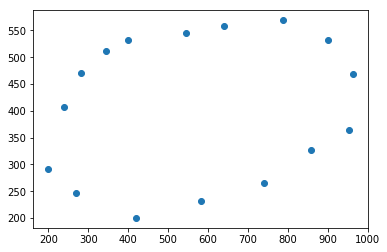

In [372]:
plt.scatter(vertices_dic_7N[sec][:,0]-im_1_min+margin,vertices_dic_7N[sec][:,1] - im_0_min + margin)

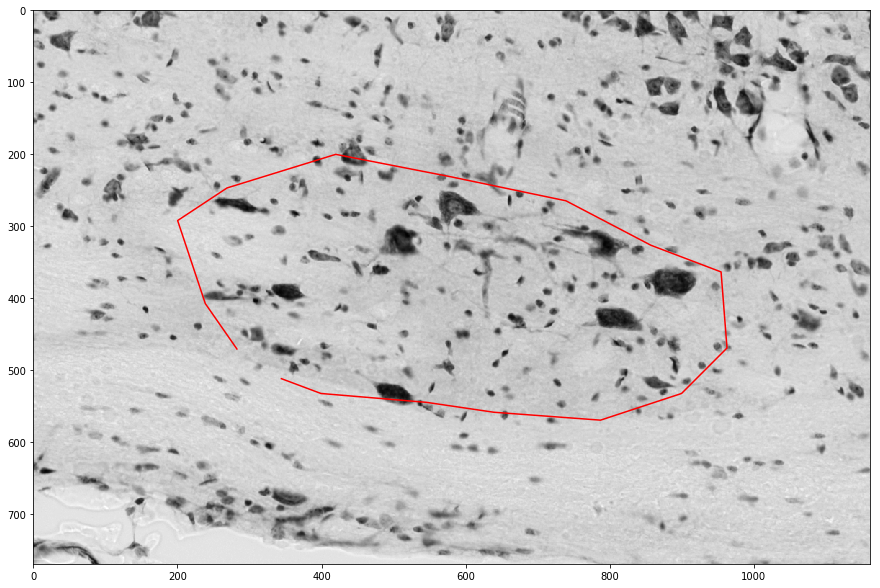

In [374]:
# Visualize the chosen structure:
plt.figure(figsize=(15,15))
plt.imshow(fun_crop_images(im_rescale[secIndex],im_0_min,im_1_min,im_0_max,im_1_max,im0max=im0max,im1max=im1max,margin=margin),cmap=plt.cm.gray)
plt.plot(vertices_dic_7N[sec][:,0]-im_1_min+margin,vertices_dic_7N[sec][:,1] - im_0_min + margin,'-r')

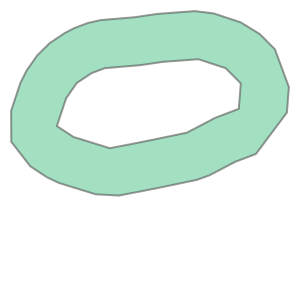

In [121]:
a = Polygon(vertices_dic_7N[sec])
surround = a.buffer(margin,resolution=2)
surround = surround.difference(a)
surround

# Load images

In [127]:
# Set examine section number range and download from S3 if not available
img_filename = []
cell_orientations = []
cell_centroids = []
cell_numbers = []
cell_contour = []
cell_global_coord = []
# secIndexList = range(200, 201)
secIndexList = sectionList_7N[0:4]


for tempIndex1 in range(len(secIndexList)):
    img_filename.append(DataManager.get_image_filepath(stack=stack, section=secIndexList[tempIndex1], resol='lossless', version='cropped'))
    
    cell_orientations.append(load_cell_data('orientation', stack, sec=secIndexList[tempIndex1]))
    cell_orientations[tempIndex1] = np.array(map(normalize_angle, cell_orientations[tempIndex1]))
    cell_centroids.append(load_cell_data('centroid',stack=stack,sec=secIndexList[tempIndex1]))
    cell_numbers.append(cell_centroids[tempIndex1].shape[0])
    cell_global_coord.append(load_cell_data('coords', stack=stack, sec=secIndexList[tempIndex1]))
    if os.path.isfile(img_filename[tempIndex1]):
        sys.stderr.write('Image file is already available. \n')
        continue
    else:
        try:
            download_from_s3(img_filename[tempIndex1])
        except:
            sys.stderr.write('Download fail. Skip this file...\n')
            continue           
            
    

Image file is already available. 
Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078_blobOrientations.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078_blobOrientations.bp /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078_blobOrientations.bp


Child returned 0
0.86 seconds.
Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078_blobCentroids.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078_blobCentroids.bp /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078_blobCentroids.bp


Child returned 0
0.57 seconds.
Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078_blobCoords.hdf && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078_blobCoords.hdf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078_blobCoords.hdf


Child returned 0
2.01 seconds.


rm -rf /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif && mkdir -p /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif


Child returned 0
Child returned 0
3.90 seconds.
Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_1_0079/MD589-N27-2015.07.30-17.49.06_MD589_1_0079_blobOrientations.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_1_0079
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_1_0079/MD589-N27-2015.07.30-17.49.06_MD589_1_0079_blobOrientations.bp /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_1_0079/MD589-N27-2015.07.30-17.49.06_MD589_1_0079_blobOrientations.bp


Child returned 0
0.53 seconds.
Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_1_0079/MD589-N27-2015.07.30-17.49.06_MD589_1_0079_blobCentroids.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_1_0079
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_1_0079/MD589-N27-2015.07.30-17.49.06_MD589_1_0079_blobCentroids.bp /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_1_0079/MD589-N27-2015.07.30-17.49.06_MD589_1_0079_blobCentroids.bp


Child returned 0
0.52 seconds.
Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_1_0079/MD589-N27-2015.07.30-17.49.06_MD589_1_0079_blobCoords.hdf && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_1_0079
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_1_0079/MD589-N27-2015.07.30-17.49.06_MD589_1_0079_blobCoords.hdf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_1_0079/MD589-N27-2015.07.30-17.49.06_MD589_1_0079_blobCoords.hdf


Child returned 0
1.96 seconds.


rm -rf /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-N27-2015.07.30-17.49.06_MD589_1_0079_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif && mkdir -p /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-N27-2015.07.30-17.49.06_MD589_1_0079_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-N27-2015.07.30-17.49.06_MD589_1_0079_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif


Child returned 0
Child returned 0
3.93 seconds.
Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079_blobOrientations.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079_blobOrientations.bp /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079_blobOrientations.bp


Child returned 0
0.54 seconds.
Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079_blobCentroids.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079_blobCentroids.bp /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079_blobCentroids.bp


Child returned 0
0.53 seconds.
Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079_blobCoords.hdf && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079_blobCoords.hdf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079_blobCoords.hdf


Child returned 0
2.16 seconds.


rm -rf /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif && mkdir -p /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif


Child returned 0
Child returned 0
3.98 seconds.


In [128]:
option_rescale_grayscale = True
option_inverse_color = False
# secIndex = 0

n_images = len(img_filename)
im_cropped = []
im_rescale = []
for imIndex in range(n_images):
    im_cropped.append(img_as_ubyte(rgb2gray(imread(img_filename[imIndex])[crop_0_min:crop_0_max, crop_1_min:crop_1_max])))
    if option_rescale_grayscale:
        im_rescale.append(fun_rescale_grayscale_image(im_cropped[imIndex],invcol=option_inverse_color))

im_cropped_0, im_cropped_1 = im_cropped[0].shape[:2]

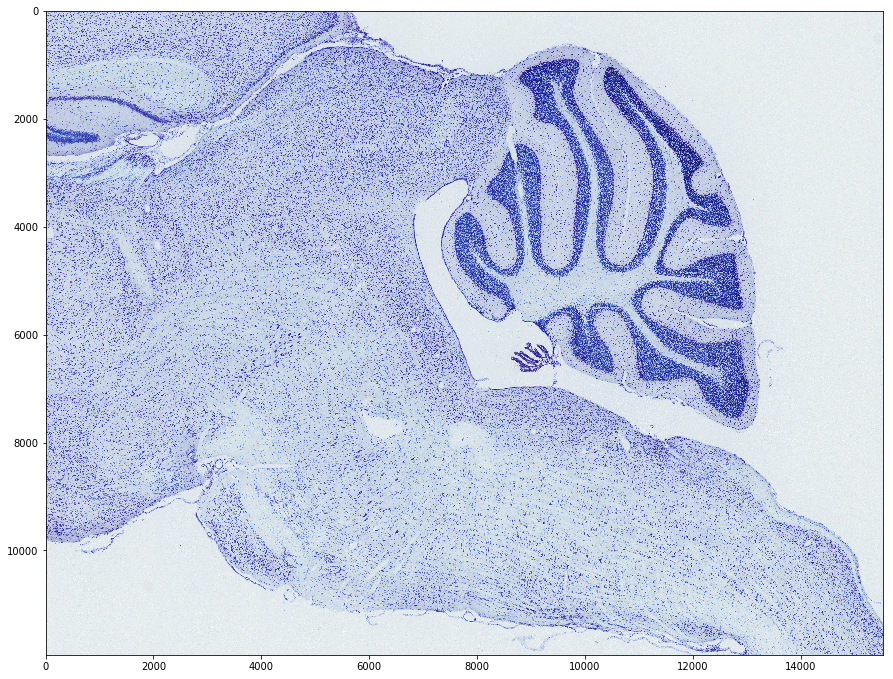

In [11]:
a = imread(img_filename[0])
plt.figure(figsize=(15,15))
plt.imshow(a)

## Reconstruct labeled image from detected cell dataset, with visualization

In [129]:
# Construct BW images
oriImL1,oriImL0 = metadata_cache['image_shape'][stack] # The order is annoying....

In [130]:
option_crop = True
option_clear_border = True
option_relabel = True
im_blob_prop = {}
im_label_ori = []
im_label = []
im_BW = []
crop_range = (crop_0_min,crop_0_max,crop_1_min,crop_1_max)
for tempSecIndex in range(n_images):
    temp_im_label, temp_im_blob_prop, _ = fun_reconstruct_labeled_image(cell_global_coord[tempSecIndex],crop_range= crop_range, 
                                                                    oriImL0=oriImL0,oriImL1=oriImL1)
    im_label.append(temp_im_label)
    im_BW.append(temp_im_label>0)
    im_blob_prop[secIndexList[tempSecIndex]]  = temp_im_blob_prop
    
n_blobs = map(len, im_blob_prop.values())

Blob Index 27659


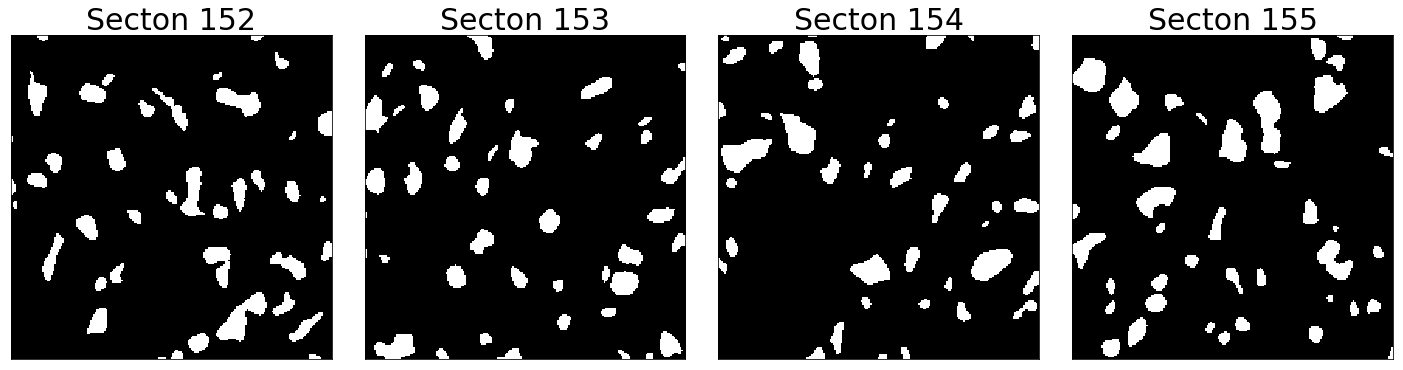

Blob Index 31246


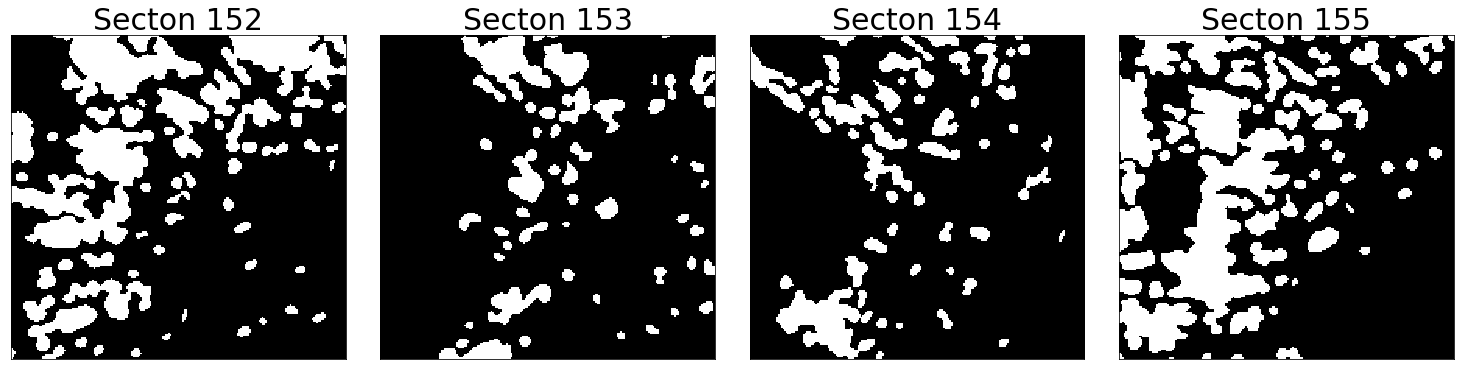

Blob Index 42396


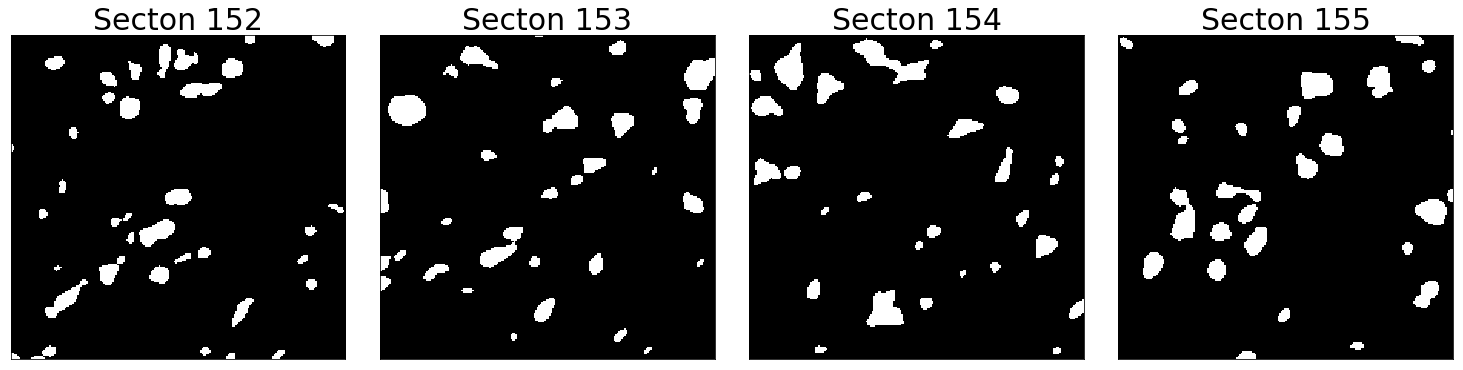

Blob Index 2601


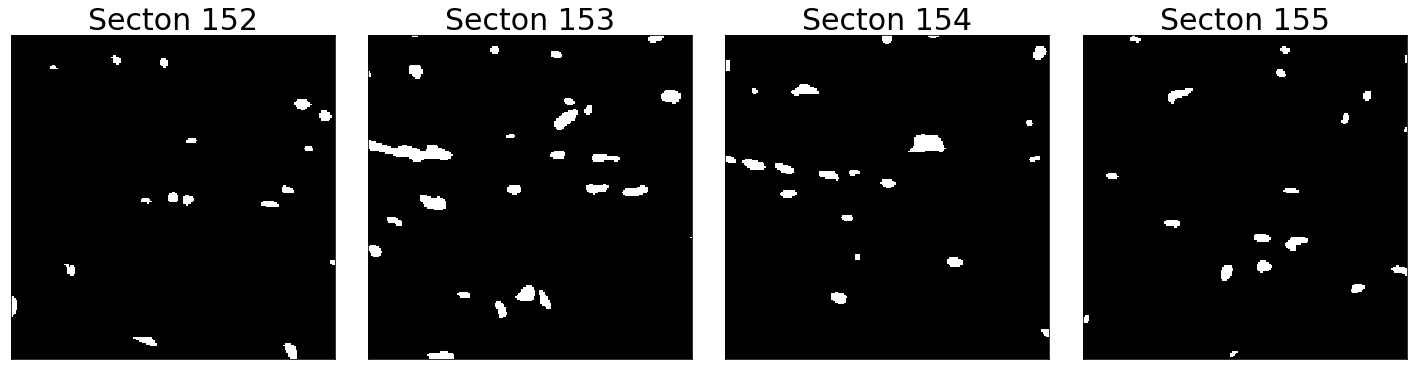

Blob Index 29238


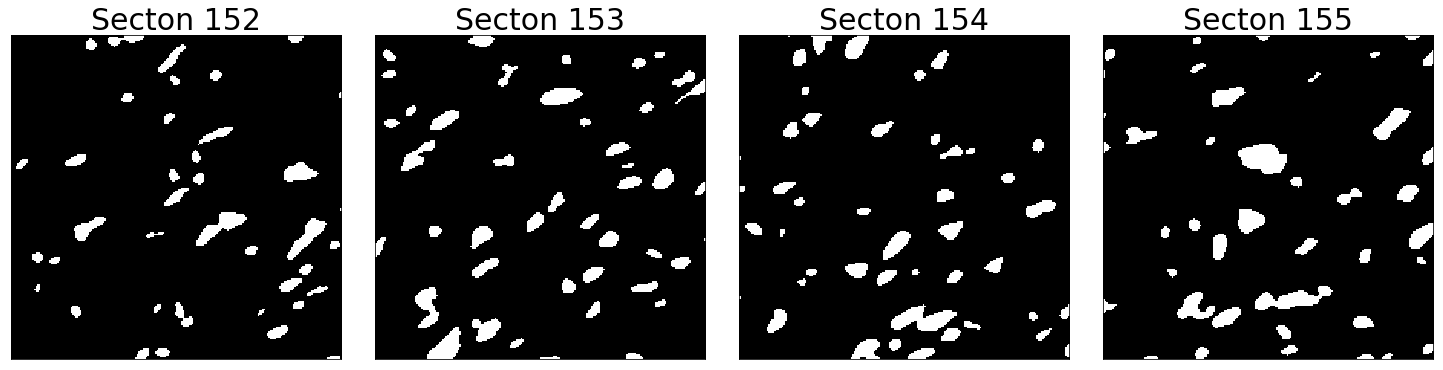

Blob Index 61007


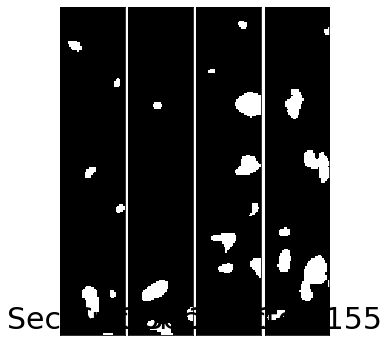

Blob Index 8796


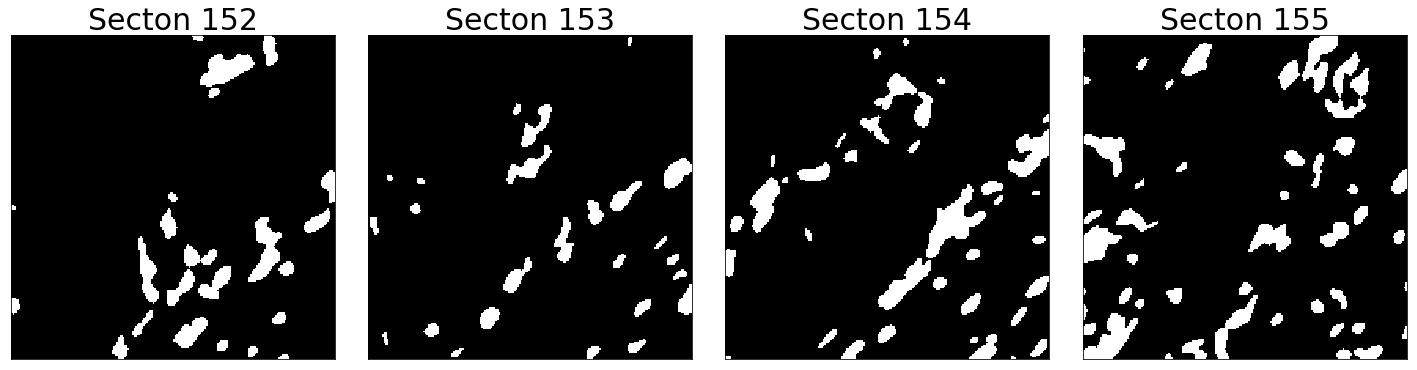

Blob Index 15312


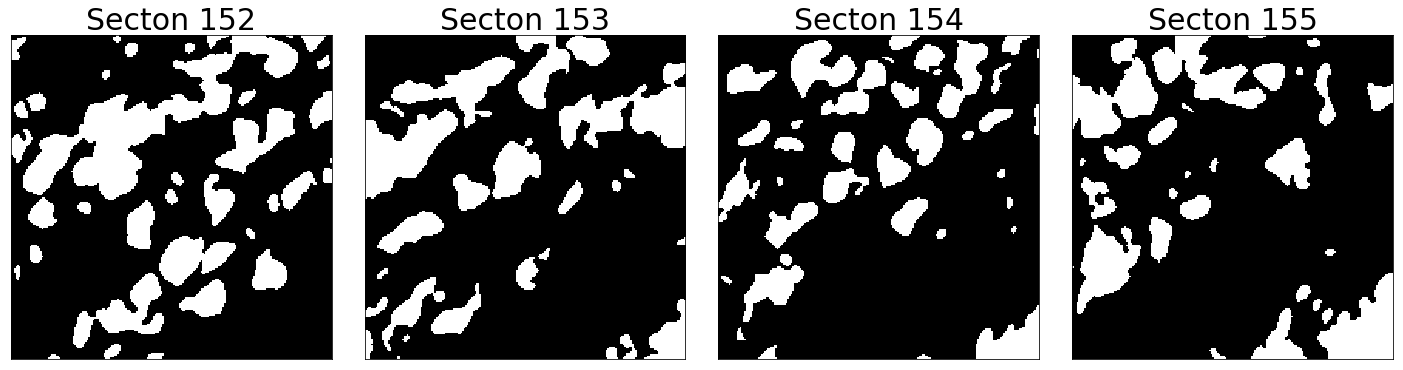

Blob Index 23949


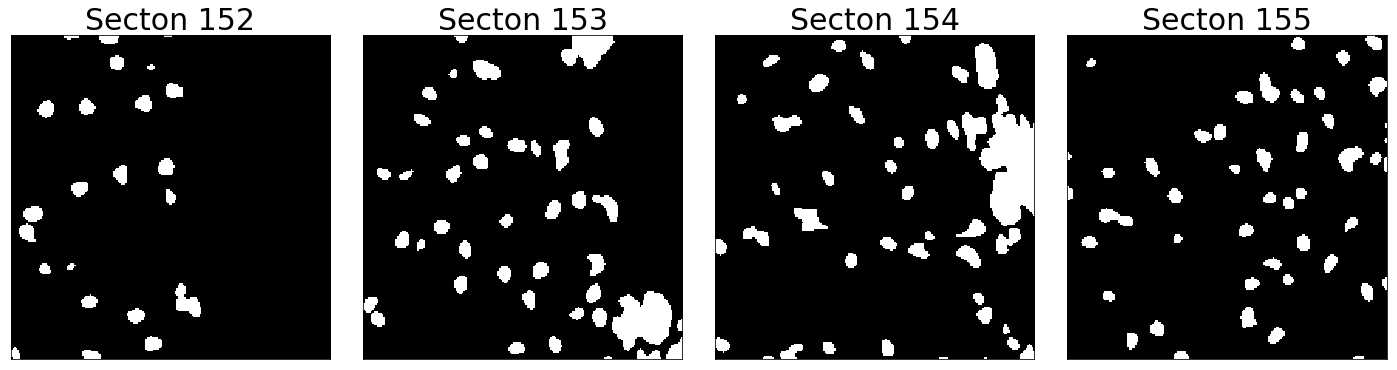

Blob Index 4019


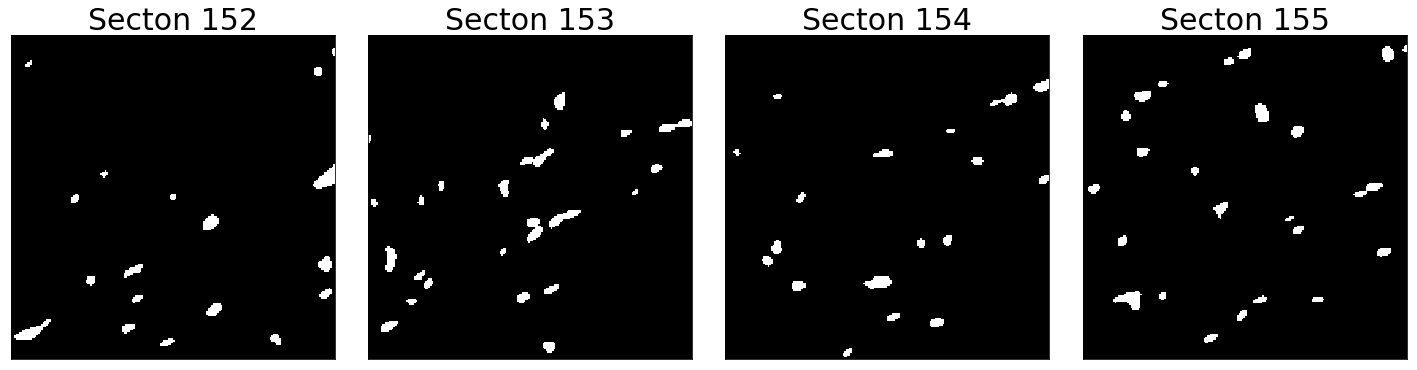

In [134]:
secIndex = 0
option_vis_blob_margin = 100
sec = 152
for tempBlobIndex in np.random.choice(range(0,n_blobs[secIndex]),10):
    print('Blob Index %d' % tempBlobIndex)
#     display_images_in_grids([fun_crop_images(im_rescale[tempSecIndex],*im_blob_prop[sec][tempBlobIndex]['bbox'],margin=option_vis_blob_margin) 
#                              for tempSecIndex in range(n_images)],
#                             titles=['Secton %d' % tempSec for tempSec in secIndexList],
#                             nc=5,cmap=plt.cm.gray)
    display_images_in_grids([fun_crop_images(im_BW[tempSecIndex],*im_blob_prop[sec][tempBlobIndex]['bbox'],margin=option_vis_blob_margin) 
                         for tempSecIndex in range(n_images)],
                        titles=['Secton %d' % tempSec for tempSec in secIndexList],
                        nc=4,cmap=plt.cm.gray)

## Get the blobs inside the selected strucutre

### Get blob properties in the next section

In [135]:
secIndex = 0
sec = secIndexList[secIndex]
blobID = 1
prop = ['centroid','eccentricity','area','orientation','moments_hu','bbox','equivalent_diameter'] # Features for comparison
o_scan_size_coeff = 5

In [193]:
# Get all the blobs inside the selected structure in the current section
temp_curr_sec_blob_centroid = [im_blob_prop[sec][tempBIdx]['centroid'] for tempBIdx in range(n_blobs[secIndex]) ]
tempPath = matplotlib.path.Path(vertices_dic_7N[sec])
tempBlobInside = tempPath.contains_points(temp_curr_sec_blob_centroid)
tempBlobIndex = np.arange(0,n_blobs[secIndex],dtype=np.int32)
tempBlobInsideIndex = tempBlobIndex[tempBlobInside]
temp_curr_BlobsProps_in_structure = np.array(im_blob_prop[sec])[tempBlobInside]
temp_curr_BlobsNum_in_structure = len(temp_curr_BlobsProps_in_structure)

# Get blobs in the margin of structure of current section
temp_PosSam_Polygon = Polygon(vertices_dic_7N[sec])
temp_surround = temp_PosSam_Polygon.buffer(margin,resolution=2)
tempPath_surr = matplotlib.path.Path(list(temp_surround.exterior.coords))
tempBlobInside_surr = tempPath_surr.contains_points(temp_curr_sec_blob_centroid)
tempBlobInside_surr = np.logical_xor(tempBlobInside,tempBlobInside_surr)
tempBlobSurrIndex = tempBlobIndex[tempBlobInside_surr]
temp_curr_BlobsProps_in_structure_surr = np.array(im_blob_prop[sec])[tempBlobInside_surr]
temp_curr_BlobsNum_in_structure_surr = len(temp_curr_BlobsProps_in_structure_surr)

# Assuming that all blobs in the structure are "typical" and all blobs in the marginal area are "Not Typical"

In [199]:
idx1 = 0
idx2 = 1
props_for_comparison = ['area', 'orientation', 'eccentricity','equivalent_diameter','moments_hu']

## Construct positive learning set

In [250]:
temp_sim = {}
temp_pos_sample = []
for idx1 in range(temp_curr_BlobsNum_in_structure):
    temp_curr_blob_props = {}
    for tempProp in props_for_comparison:
        temp_prop_value = []
        for blobIndex in range(temp_curr_BlobsNum_in_structure):
            if blobIndex != idx1:
                temp_prop_value.append(temp_curr_BlobsProps_in_structure[blobIndex][tempProp])
        temp_curr_blob_props[tempProp] = temp_prop_value   
        
    # Generate positive sample. (num_sample, num_features = 11)     
    for prop in props_for_comparison:
        temp_sim[prop] = fun_similarity(temp_curr_BlobsProps_in_structure[idx1][prop], temp_curr_blob_props[prop],distance_type=prop)
    temp_sim_matrix = np.column_stack((temp_sim[temp_prop] for temp_prop in props_for_comparison))
    temp_pos_sample.append(temp_sim_matrix)
temp_pos_sample = np.vstack(tuple(temp_pos_sample))
temp_pos_label = np.array(np.ones([np.size(temp_pos_sample,axis=0)]),dtype=np.bool)

## Construct negative learning set

In [251]:
temp_sim = {}
temp_curr_surrblob_props = {}
temp_neg_sample = []
for idx1 in range(temp_curr_BlobsNum_in_structure):
    for tempProp in props_for_comparison:
        temp_prop_value = []
        for blobIndex in range(temp_curr_BlobsNum_in_structure_surr):
            temp_prop_value.append(temp_curr_BlobsProps_in_structure_surr[blobIndex][tempProp])
        temp_curr_surrblob_props[tempProp] = temp_prop_value

    for prop in props_for_comparison:
        temp_sim[prop] = fun_similarity(temp_curr_BlobsProps_in_structure[idx1][prop], temp_curr_surrblob_props[prop],distance_type=prop)
    temp_sim_matrix = np.column_stack((temp_sim[temp_prop] for temp_prop in props_for_comparison))
    temp_neg_sample.append(temp_sim_matrix)
temp_neg_sample = np.vstack(tuple(temp_neg_sample))
temp_neg_label = np.array(np.zeros([np.size(temp_neg_sample,axis=0)]),dtype=np.bool)

In [261]:
training_set = np.vstack((temp_pos_sample,temp_neg_sample))
training_label = np.concatenate((temp_pos_label,temp_neg_label))

# Learning

In [253]:
import sklearn

In [299]:
model_perceptron = sklearn.linear_model.perceptron.Perceptron(fit_intercept=False,n_iter=10,shuffle=True).fit(training_set,training_label)
training_accuracy = model_perceptron.score(training_set,training_label)
print 'The training accuracy is %f' %training_accuracy
print 'Coefficients are:', model_perceptron.coef_

The training accuracy is 0.698409
Coefficients are: [[-1.16172491 -1.92449348  0.52881113 -1.5748488  -0.22342115 -0.77072968
   0.4709289  -0.21463786 -1.19796279  0.37325647  1.72405645]]


### Accuracy vs n_iter

In [314]:
import random

In [327]:
n_iteration = range(1,51)
training_accuracy = []
for n_iter in n_iteration:
    model_perceptron = sklearn.linear_model.perceptron.Perceptron(fit_intercept=False,n_iter=n_iter,shuffle=True,random_state=random.seed()).fit(training_set,training_label)
    training_accuracy.append(model_perceptron.score(training_set,training_label))

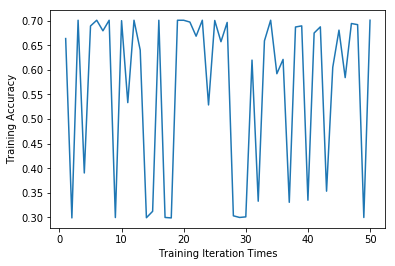

In [328]:
plt.plot(n_iteration,training_accuracy);
plt.xlabel('Training Iteration Times')
plt.ylabel('Training Accuracy')

### Accuracy replicablility

In [351]:
n_iteration = range(1,51)
training_accuracy = []
for n_iter in n_iteration:
    model_perceptron = sklearn.linear_model.perceptron.Perceptron(fit_intercept=False,n_iter=10,shuffle=True,random_state=random.seed()).fit(training_set,training_label)
    training_accuracy.append(model_perceptron.score(training_set,training_label))

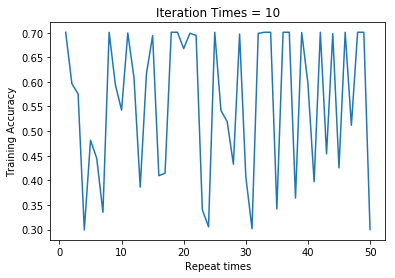

In [352]:
plt.plot(n_iteration,training_accuracy);
plt.xlabel('Repeat times')
plt.ylabel('Training Accuracy')
plt.title('Iteration Times = 10')

### Trun off shuffle

In [378]:
n_iteration = range(1,51)
training_accuracy = []
for n_iter in n_iteration:
    model_perceptron = sklearn.linear_model.perceptron.Perceptron(fit_intercept=False,n_iter=10,shuffle=False,random_state=random.seed()).fit(training_set,training_label)
    training_accuracy.append(model_perceptron.score(training_set,training_label))

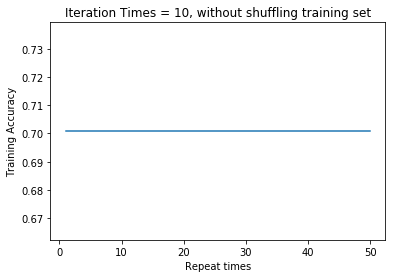

In [379]:
plt.plot(n_iteration,training_accuracy);
plt.xlabel('Repeat times')
plt.ylabel('Training Accuracy')
plt.title('Iteration Times = 10, without shuffling training set')

In [380]:
model_perceptron.coef_

array([[ 1.68751378, -2.72886974, -1.78505416, -0.60496255, -2.93612604,
        -0.39224923, -1.24332215, -1.41798945, -2.01186567,  0.59866149,
         1.22583114]])

# Select big cells in the structure as positive training set
Problems: 
1. Involving manually set parameters for specifying "large" cells. 